# Setup

In [2]:
import os
import pickle
import torch
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
import torchvision.transforms.functional as VF
import torchvision.transforms.v2 as T
import torch.nn as nn
from torchvision.models import resnet18
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision
from torchvision.ops import box_iou
import matplotlib.pyplot as plt
from itertools import cycle
from tqdm.notebook import tqdm
import random
import numpy as np
import wandb
from PIL import Image
import torchvision.transforms as transforms


In [3]:
# DATA_AUGMENTATION = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# if torch.mps.is_available():
#     device = "mps"
print(device)

cpu


In [4]:
NUM_KEYPOINTS = 17
DETECTION_THRESHOLD = 0.8
# IOU_THRESHOLD = 0.5
CROP_SIZE = 256

In [5]:
class CropTransform:
    def __init__(self, augmentation=False):
        if augmentation:
            self.transform = transforms.Compose([
                transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
                transforms.RandomApply([transforms.RandomGrayscale(p=1.0)], p=0.2),
                transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
    
    def __call__(self, img):
        return self.transform(img)


In [6]:
class KeypointCropModel(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Remove avgpool and fc
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, NUM_KEYPOINTS * 3)  # Predict x, y, confidence for each keypoint
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = x.view(-1, NUM_KEYPOINTS, 3)
        return x


In [7]:
class PersonKeypointPipeline:
    def __init__(self, detector, keypoint_model, crop_transform, device='cpu', detection_threshold=0.8, crop_size=256):
        self.detector = detector.to(device)
        self.detector.eval()
        self.keypoint_model = keypoint_model.to(device)
        self.keypoint_model.eval()
        self.crop_transform = crop_transform
        self.device = device
        self.detection_threshold = detection_threshold
        self.crop_size = crop_size

    def predict(self, pil_img):
        """
        Args:
            pil_img: PIL.Image.Image, RGB image

        Returns:
            List of dicts, each with:
                - 'box': [x1, y1, x2, y2]
                - 'keypoints': np.ndarray of shape (NUM_KEYPOINTS, 3)
        """
        # Detect people
        img_tensor = T.Compose([T.ToTensor()])(pil_img).unsqueeze(0).to(self.device)
        with torch.no_grad():
            detections = self.detector(img_tensor)[0]

        person_mask = (detections['labels'] == 1) & (detections['scores'] > self.detection_threshold)
        boxes = detections['boxes'][person_mask].cpu().numpy()

        results = []
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            crop = pil_img.crop((x1, y1, x2, y2)).resize((self.crop_size, self.crop_size))
            crop_tensor = self.crop_transform(crop).unsqueeze(0).to(self.device)
            with torch.no_grad():
                pred_kps = self.keypoint_model(crop_tensor)[0].cpu()
            pred_kps[:, 2] = torch.sigmoid(pred_kps[:, 2])

            # Map keypoints back to original image coordinates
            box_w, box_h = x2 - x1, y2 - y1
            mapped_kps = []
            for kp in pred_kps:
                orig_x = kp[0] * (box_w / self.crop_size) + x1
                orig_y = kp[1] * (box_h / self.crop_size) + y1
                visible = 1 if kp[2] > 0.5 else 0
                mapped_kps.append([orig_x.item(), orig_y.item(), visible])
            mapped_kps = np.array(mapped_kps)

            results.append({'box': [x1, y1, x2, y2], 'keypoints': mapped_kps})

        return results


# Generating pipeline

In [8]:
# Load the trained keypoint model
model = KeypointCropModel().to(device)
model.load_state_dict(torch.load("../../models/bb_23loss_keypoint_crop_model.pth", map_location=device))
model.eval()

# Load person bb detector
detector = fasterrcnn_resnet50_fpn(pretrained=True).to(device)
detector.eval()


/opt/homebrew/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/homebrew/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
pipeline = PersonKeypointPipeline(
    detector=detector,
    keypoint_model=model,
    crop_transform=CropTransform(augmentation=False),
    device=device,
    detection_threshold=DETECTION_THRESHOLD,
    crop_size=CROP_SIZE
)

torch.save(pipeline, "../../models/keypoints_model_pipeline.pth")

# Using pipeline

In [10]:
loaded_pipeline = torch.load("../../models/keypoints_model_pipeline.pth", map_location=device, weights_only=False)


/opt/homebrew/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/var/folders/zv/_jvqr_vd7lb9_6kzvdb400sm0000gn/T/ipykernel_21533/3501766914.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(predictions))


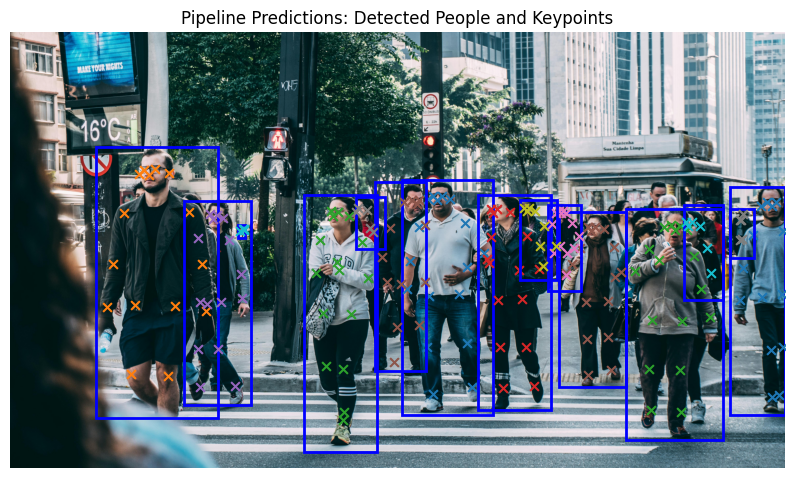

[{'box': [3035, 1146, 3739, 2968], 'keypoints': array([[3.30593213e+03, 1.30015662e+03, 1.00000000e+00],
       [3.34032251e+03, 1.26766003e+03, 1.00000000e+00],
       [3.27445776e+03, 1.27005176e+03, 1.00000000e+00],
       [3.40662573e+03, 1.29057422e+03, 1.00000000e+00],
       [3.23873608e+03, 1.29486621e+03, 1.00000000e+00],
       [3.51994238e+03, 1.47989075e+03, 1.00000000e+00],
       [3.16521802e+03, 1.50845337e+03, 1.00000000e+00],
       [3.66905835e+03, 1.71250708e+03, 1.00000000e+00],
       [3.09752783e+03, 1.76933044e+03, 1.00000000e+00],
       [3.53434399e+03, 1.81948706e+03, 1.00000000e+00],
       [3.07447314e+03, 1.98896582e+03, 1.00000000e+00],
       [3.47438525e+03, 2.02562830e+03, 1.00000000e+00],
       [3.24568896e+03, 2.04416125e+03, 1.00000000e+00],
       [3.53946533e+03, 2.40514893e+03, 1.00000000e+00],
       [3.22882861e+03, 2.43844092e+03, 1.00000000e+00],
       [3.57764844e+03, 2.74755615e+03, 1.00000000e+00],
       [3.27457812e+03, 2.80646582e+03, 

In [11]:
random_img_path = os.path.join('./images', random.choice(os.listdir('./images')))
random_img = Image.open(random_img_path).convert('RGB')

predictions = loaded_pipeline.predict(random_img)


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(random_img)
colors = plt.cm.get_cmap('tab10', len(predictions))
for person in predictions:
    x1, y1, x2, y2 = person['box']
    kps = person['keypoints']

    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='blue', linewidth=2)
    ax.add_patch(rect)

    # Assign a unique color for each person
    color = colors(predictions.index(person))
    for kp in kps:
        if kp[2] == 1:
            ax.scatter(kp[0], kp[1], color=color, marker='x', s=40)
ax.set_title("Pipeline Predictions: Detected People and Keypoints")
ax.axis('off')
plt.show()


print(predictions)